In [1]:
!pip install nltk

!pip3 install -U nltk

In [2]:
import pandas as pd
import os
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import numpy as np
from keras import utils
from tensorflow.keras.callbacks import TensorBoard
from time import time



In [3]:

nltk.download('wordnet')

nltk.download('stopwords')
# stop words
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chaimae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaimae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
answers = pd.read_csv("../datasets/answers.csv", encoding='utf-8')
answers

,question_id,answer,grade
0,1,محمد صلى الله عليه وسلم,2.0
1,1,خاتم الأنبياء,2.0
2,1,الرسول الأعظم,2.0
3,1,سيد المرسلين,2.0
4,1,صاحب الرسالة الخاتمة,2.0
...,...,...,...
986,10,الكهف,0.0
987,10,الفرقان,0.0
988,10,آل عمران,0.0
989,10,الإسراء,0.0


In [5]:
# Supprimer les lignes avec des valeurs manquantes
answers['answer'].isnull().sum()
answers.dropna(inplace=True)

In [6]:
# Convertir 'grade' en int64 
answers['grade'] = answers['grade'].astype(int)
# Conversion 'question' et 'answer' en type 'str' 
answers['answer'] = answers['answer'].astype(str)

In [7]:
# Suppression des doublons :
answers.drop_duplicates(inplace=True)
#définir 'id_question' comme index
answers.set_index('question_id', inplace=True)

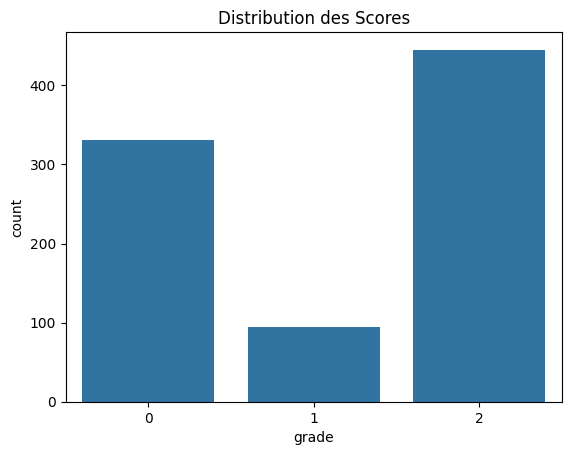

In [8]:
# Distribution des scores
sns.countplot(x='grade', data=answers)
plt.title('Distribution des Scores')
plt.show()

In [9]:
# Function to clean text
def clean_text(text):
    # Define the characters you want to remove
    characters_to_remove = ["''", ':', '؟']

    # Remove specified characters
    for char in characters_to_remove:
        text = text.replace(char, '')

    # Remove `` and ''
    text = text.replace('``', '').replace("''", '')

    return text



# Apply the clean_text function to the 'answer' column in the 'answers' DataFrame
answers['answer'] = answers['answer'].apply(clean_text)


In [10]:
answers.head(10)

,answer,grade
question_id,,
1,محمد صلى الله عليه وسلم,2
1,خاتم الأنبياء,2
1,الرسول الأعظم,2
1,سيد المرسلين,2
1,صاحب الرسالة الخاتمة,2
1,النبي الذي لا يبعث بعده نبي,2
1,صاحب الشريعة الخاتمة,2
1,نبي الله الذي أرسله الله إلى جميع الناس، وختم ...,2
1,النبي الذي أكرمه الله بآيات كثيرة في القرآن ال...,2


In [11]:
!pip install -U nltk

In [12]:
stu_answers = answers['answer']
scores = answers['grade']
scores = tf.keras.utils.to_categorical(
    scores, num_classes=3, dtype='float32'
)


In [13]:
from nltk.stem.arlstem import ARLSTem
stemmer = ARLSTem()
# Function to clean and preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.strip())

    # Removal of stop words
    tokens = [word for word in tokens if word not in arb_stopwords]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]

    # Concatenate tokens into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text, lemmatized_tokens

answers['answer'], answers['answer'] = zip(*answers['answer'].apply(preprocess_text))


In [14]:
answers

,answer,grade
question_id,,
1,"[محمد, صلي, الل, سلم]",2
1,"[خاتم, نبيء]",2
1,"[رسول, اعظم]",2
1,"[سيد, مرسل]",2
1,"[صاحب, رسال, خاتم]",2
...,...,...
10,[كهف],0
10,[فرق],0
10,"[ال, عمر]",0


In [15]:

!pip3 install gensim 


In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec -P ./


'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [17]:
from gensim.models import KeyedVectors
absolute_path = "./wiki.ar.vec"  # Replace with the actual absolute path
fasttext_model = KeyedVectors.load_word2vec_format(absolute_path)


In [18]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#train tokenization
tokenizer = Tokenizer(filters=''''!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''''' )
combined_texts = answers['answer']
tokenizer.fit_on_texts(combined_texts)
sequences = tokenizer.texts_to_sequences(combined_texts)
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences, max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1

In [19]:
# Word Embedding
from keras.layers import Embedding
import numpy as np

EMBEDDING_DIM = 300
num_words = len(word2idx) + 1

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
count = 0  # Initialize count here
for word, idx in word2idx.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model.get_vector(word)
    else:
        count += 1
        print("Word not exist in vocab: " + word)
        print(count)

Word not exist in vocab: انعام،
1
Word not exist in vocab: 3
2
Word not exist in vocab: ''
3
Word not exist in vocab: ``
4
Word not exist in vocab: ارضع
5
Word not exist in vocab: مرضع
6
Word not exist in vocab: بتلع
7
Word not exist in vocab: فتتح
8
Word not exist in vocab: نبيء
9
Word not exist in vocab: اسلام،
10
Word not exist in vocab: ربم
11
Word not exist in vocab: حتوي
12
Word not exist in vocab: خري
13
Word not exist in vocab: اريخ
14
Word not exist in vocab: قران،
15
Word not exist in vocab: يتامي
16
Word not exist in vocab: شريع
17
Word not exist in vocab: عقوب
18
Word not exist in vocab: 5
19
Word not exist in vocab: فاطرهي
20
Word not exist in vocab: بالل
21
Word not exist in vocab: وزيع
22
Word not exist in vocab: 10
23
Word not exist in vocab: عالمين،
24
Word not exist in vocab: بتدئ
25
Word not exist in vocab: مائد
26
Word not exist in vocab: بعيسي
27
Word not exist in vocab: ختر
28
Word not exist in vocab: هب،
29
Word not exist in vocab: بدعو
30
Word not exist in vocab

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30983999, -0.13467   , -0.73664999, ..., -0.32602999,
        -0.21698999, -0.29073   ],
       [ 0.21615   ,  0.21889   , -0.049481  , ..., -0.13906001,
         0.12826   ,  0.36548001],
       ...,
       [-0.37913001,  0.90614003, -0.30304   , ..., -0.21646   ,
         0.085595  ,  0.34847   ],
       [ 0.024534  ,  0.40884   , -0.45969999, ..., -0.34301001,
         0.17645   , -0.40713999],
       [-0.27902001, -0.022783  , -0.23921999, ..., -0.31531999,
         0.037558  ,  0.30046999]])

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim ,embedding_matrix):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,weights=[embedding_matrix], output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sequences, scores, test_size=0.2)

In [24]:
num_heads = 1  # Number of attention heads
ff_dim = 8  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_sequence_length,))
embedding_layer = TokenAndPositionEmbedding(max_sequence_length, vocab_size, EMBEDDING_DIM,embedding_matrix)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(EMBEDDING_DIM, num_heads, ff_dim,0.3)
x = transformer_block(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.1)(x)
#x = layers.Dense(5, activation="relu")(x)
#x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
import tensorflow_addons as tfa
#https://neptune.ai/blog/tensorboard-tutorial
tensorboard_callback = TensorBoard(log_dir="./logstr")
#Early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3,verbose=1,mode='min')
keras_callbacks = [
  tensorboard_callback,es_callback
]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="categorical_crossentropy",  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),f1_m,tfa.metrics.CohenKappa(num_classes=3)])
#model.save('transformer_model.h5')
model.summary()


c:\Users\chaimae\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chaimae\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to en

NotImplementedError: 
Layer TokenAndPositionEmbedding was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
%reload_ext tensorboard
log_folder = 'logstr'
time_start = time()
hisotry = model.fit(
    X_train, y_train, batch_size=256, epochs=100,callbacks=keras_callbacks,validation_data=(X_test, y_test))
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Layer TokenAndPositionEmbedding was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/100


3/3 [==============================] - 16s 1s/step - loss: 1.9887 - accuracy: 0.3549 - precision: 0.3600 - recall: 0.3491 - f1_m: 0.3599 - cohen_kappa: 0.0236 - val_loss: 1.6084 - val_accuracy: 0.5862 - val_precision: 0.5862 - val_recall: 0.5862 - val_f1_m: 0.5862 - val_cohen_kappa: 0.2329
Epoch 2/100
3/3 [==============================] - 2s 547ms/step - loss: 1.4353 - accuracy: 0.5876 - precision

In [ ]:
scores_trainig = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: %f%%" % (scores_trainig[0]))
print("Training Accuracy: %.2f%%" % (scores_trainig[1]*100))
print("Training Precision: %.2f%%" % (scores_trainig[2]*100))
print("Training Recall: %.2f%%" % (scores_trainig[3]*100))
print("Training F1 Score: %.2f%%" % (scores_trainig[4]*100))
print("Training Cohen Kappa: %.2f%%" % (scores_trainig[5]*100))

22/22 [==============================] - 1s 30ms/step - loss: 0.0577 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9770 - f1_m: 0.9779 - cohen_kappa: 0.9624
Training Loss: 0.057733%
Training Accuracy: 97.84%
Training Precision: 97.84%
Training Recall: 97.70%
Training F1 Score: 97.79%
Training Cohen Kappa: 96.24%


In [ ]:
scores_test = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss: %f%%" % (scores_test[0]))
print("Test Accuracy: %.2f%%" % (scores_test[1]*100))
print("Test Precision: %.2f%%" % (scores_test[2]*100))
print("Test Recall: %.2f%%" % (scores_test[3]*100))
print("Test F1 Score: %.2f%%" % (scores_test[4]*100))
print("Test Cohen Kappa: %.2f%%" % (scores_test[5]*100))

6/6 [==============================] - 0s 21ms/step - loss: 1.1529 - accuracy: 0.7529 - precision: 0.7544 - recall: 0.7414 - f1_m: 0.7514 - cohen_kappa: 0.5723
Test Loss: 1.152943%
Test Accuracy: 75.29%
Test Precision: 75.44%
Test Recall: 74.14%
Test F1 Score: 75.14%
Test Cohen Kappa: 57.23%


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_m', 'cohen_kappa', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_m', 'val_cohen_kappa'])


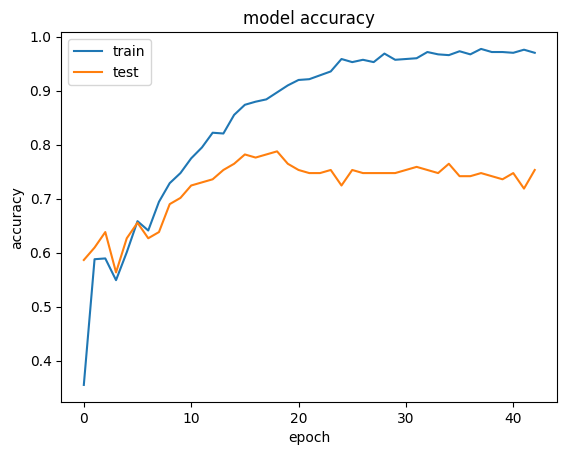

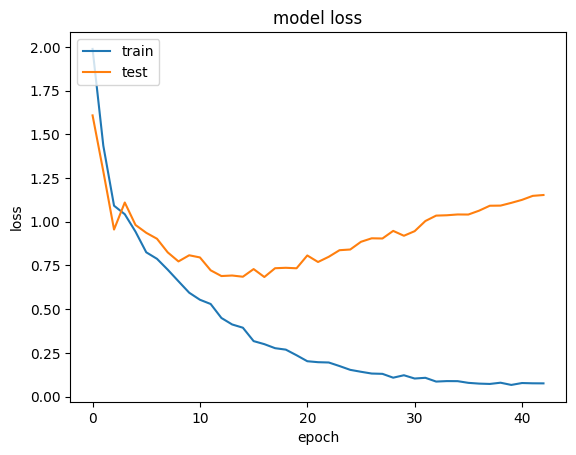

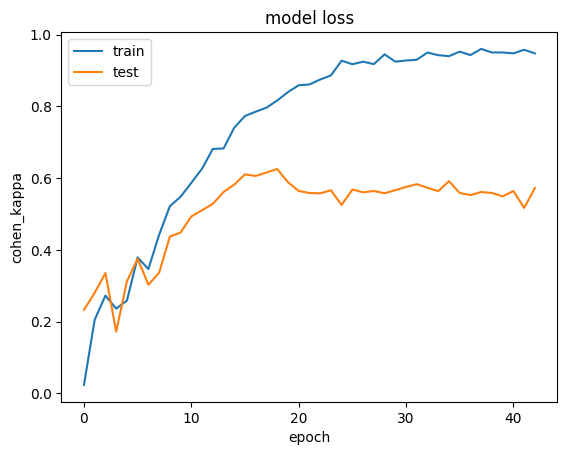

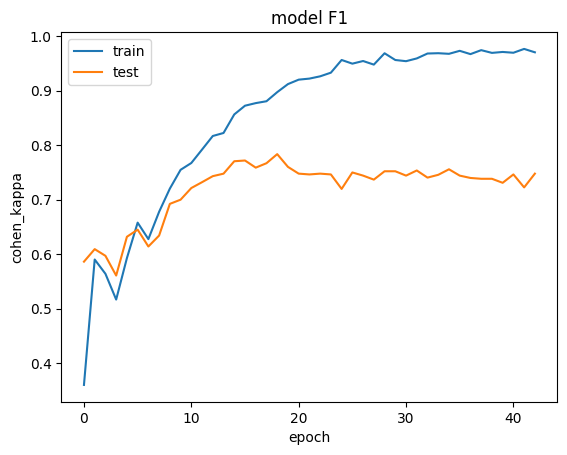

In [ ]:
'''
%reload_ext tensorboard
log_folder = 'logstr'
%tensorboard --logdir={log_folder}

'''
import matplotlib.pyplot as plt
print(hisotry.history.keys())

# summarize history for accuracy
plt.plot(hisotry.history['accuracy'])
plt.plot(hisotry.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hisotry.history['loss'])
plt.plot(hisotry.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for kappa
plt.plot(hisotry.history['cohen_kappa'])
plt.plot(hisotry.history['val_cohen_kappa'])
plt.title('model loss')
plt.ylabel('cohen_kappa')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for kappa
plt.plot(hisotry.history['f1_m'])
plt.plot(hisotry.history['val_f1_m'])
plt.title('model F1')
plt.ylabel('cohen_kappa')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
